# Claim Severity Prediction

**Objective:** Build and evaluate regression models to predict **claim amount** (`TotalClaims`) for policies that have a claim (`HadClaim = True`).

- **Target:** `TotalClaims` (on the subset where `HadClaim` is `True`)
- **Evaluation Metrics:**  
  - **RMSE** (Root Mean Squared Error)  
  - **R² Score**

**Outline of Steps:**
1. Imports & Setup  
2. Load & Clean Data  
3. Subset to Claims & Define X, y  
4. Feature Engineering (Log transform, date features, encoding, dropping irrelevant columns)  
5. Train‑Test Split  
6. Model Training & Evaluation  
7. Visualization of Results (metrics & decision tree)  
8. Hyperparameter Tuning & Final Model  
9. Save Best Model


In [1]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.path.abspath('../../src'))
from models import split_data, train_models, evaluate_model, plot_metrics, plot_decision_tree,plot_shap_summary
from Data_Processing import load_and_clean_data, encode_categoricals, scale_and_transform
import joblib


In [2]:
df = load_and_clean_data("../../Data/cleaned_data_for_StatisticalAnalysis.csv")
print(f"✅ Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
df.columns
df.dtypes

c:\Users\adoni\Desktop\KAIM COURSE\WEEK-3\InsuranceRiskAnalysisAndPredictiveModeling\src\Data_Processing.py:17: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


✅ Data loaded: 618319 rows, 24 columns


UnderwrittenCoverID           int64
PolicyID                      int64
TransactionMonth             object
IsVATRegistered                bool
Gender                       object
Province                     object
PostalCode                    int64
MainCrestaZone               object
mmcode                      float64
VehicleType                  object
RegistrationYear              int64
Cylinders                   float64
cubiccapacity               float64
kilowatts                   float64
NumberOfDoors               float64
SumInsured                  float64
CalculatedPremiumPerTerm    float64
CoverType                    object
StatutoryRiskType            object
TotalPremium                float64
TotalClaims                 float64
LossRatio                   float64
Margin                      float64
HadClaim                       bool
dtype: object

In [3]:
# check column names
df.columns

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Gender', 'Province', 'PostalCode', 'MainCrestaZone',
       'mmcode', 'VehicleType', 'RegistrationYear', 'Cylinders',
       'cubiccapacity', 'kilowatts', 'NumberOfDoors', 'SumInsured',
       'CalculatedPremiumPerTerm', 'CoverType', 'StatutoryRiskType',
       'TotalPremium', 'TotalClaims', 'LossRatio', 'Margin', 'HadClaim'],
      dtype='object')

In [4]:
# Subset to only those with a claim
df_sev = df[df['HadClaim'] == 1].copy()
print(f"▶️ Subset for severity: {df_sev.shape[0]} rows")

# Define target and features
y = df_sev['TotalClaims']
X = df_sev.drop(columns=['TotalClaims', 'Margin', 'LossRatio', 'HadClaim',"PolicyID","UnderwrittenCoverID" ])


▶️ Subset for severity: 2788 rows


In [5]:
# Date features & vehicle age
X['TransactionMonth'] = pd.to_datetime(X['TransactionMonth'])
X['Month'] = X['TransactionMonth'].dt.month
X['VehicleAge'] = X['TransactionMonth'].dt.year - X['RegistrationYear']
X = X.drop(columns=['TransactionMonth', 'RegistrationYear'])

# First few columns of x
X.head()

,IsVATRegistered,Gender,Province,PostalCode,MainCrestaZone,mmcode,VehicleType,Cylinders,cubiccapacity,kilowatts,NumberOfDoors,SumInsured,CalculatedPremiumPerTerm,CoverType,StatutoryRiskType,TotalPremium,Month,VehicleAge
149,False,Not specified,Gauteng,1982,Transvaal (all except Pretoria),4042080.0,Passenger Vehicle,4.0,1781.0,118.0,4.0,208800.00,891.8912,Own Damage,IFRS Constant,0.000000,10,3
222,True,Not specified,Gauteng,1625,Rand East,22089200.0,Passenger Vehicle,6.0,3984.0,182.0,5.0,0.01,25.0000,Windscreen,IFRS Constant,21.929825,3,9
1200,False,Not specified,Gauteng,2066,Johannesburg,5037006.0,Passenger Vehicle,4.0,1598.0,100.0,4.0,408000.00,1383.8337,Own Damage,IFRS Constant,1213.889211,4,1
1386,False,Not specified,KwaZulu-Natal,4093,Natal (Durban),64082300.0,Medium Commercial,5.0,2459.0,80.0,2.0,206900.00,735.3199,Own Damage,IFRS Constant,645.017456,10,5
1498,False,Not specified,Gauteng,2066,Johannesburg,5037006.0,Passenger Vehicle,4.0,1598.0,100.0,4.0,7000.00,85.0000,Income Protector,IFRS Constant,74.561404,4,1


In [6]:
#  Encode and scale
X_enc = encode_categoricals(X)
X_prepared = scale_and_transform(X_enc)

print(f"⚙️ Features after encoding & scaling: {X_prepared.shape[1]} columns")

⚙️ Features after encoding & scaling: 52 columns


In [7]:
X_prepared.columns

Index(['IsVATRegistered', 'PostalCode', 'mmcode', 'Cylinders', 'cubiccapacity',
       'kilowatts', 'NumberOfDoors', 'SumInsured', 'CalculatedPremiumPerTerm',
       'TotalPremium', 'Month', 'VehicleAge', 'Province_Free State',
       'Province_Gauteng', 'Province_KwaZulu-Natal', 'Province_Limpopo',
       'Province_Mpumalanga', 'Province_North West', 'Province_Northern Cape',
       'Province_Western Cape', 'MainCrestaZone_Cape Province (Cape Town)',
       'MainCrestaZone_Cape Province (East and North of Cape Town)',
       'MainCrestaZone_Ciskei, Cape Mid 1', 'MainCrestaZone_East London',
       'MainCrestaZone_Johannesburg',
       'MainCrestaZone_Karoo 1 (Northeast of Cape Town)',
       'MainCrestaZone_Langkloof, Coast 2, Coast 1', 'MainCrestaZone_Natal',
       'MainCrestaZone_Natal (Durban)', 'MainCrestaZone_Oranje Free State',
       'MainCrestaZone_Port Elizabeth', 'MainCrestaZone_Rand East',
       'MainCrestaZone_Tembu 2, Cape Mid 2, Cape Mid West, Tembu 1',
       'MainCre

In [8]:
# Split into train and test
X_train, X_test, y_train, y_test = split_data(X_prepared, y, test_size=0.2, random_state=42)
print(f"🔨 Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples")

🔨 Training on 2230 samples, testing on 558 samples


In [9]:
# Train all models
models = train_models(X_train, y_train)
print("✅ Models trained")
print(models)

✅ Models trained
{'LinearRegression': LinearRegression(), 'DecisionTree': DecisionTreeRegressor(random_state=42), 'RandomForest': RandomForestRegressor(random_state=42), 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)}


In [10]:
# Evaluate each model
results = {}
for name, model in models.items():
    mae, mse, r2, _ = evaluate_model(model, X_test, y_test)
    results[name] = (mae, mse, r2)
    print(f"{name}: MAE={mae:.2f}, MSE={mse:.2f}, R²={r2:.3f}")


LinearRegression: MAE=17181.84, MSE=1112580756.37, R²=0.308
DecisionTree: MAE=19029.68, MSE=1773524595.05, R²=-0.103
RandomForest: MAE=16387.61, MSE=1197678706.04, R²=0.255
XGBoost: MAE=17838.41, MSE=1482146427.96, R²=0.078


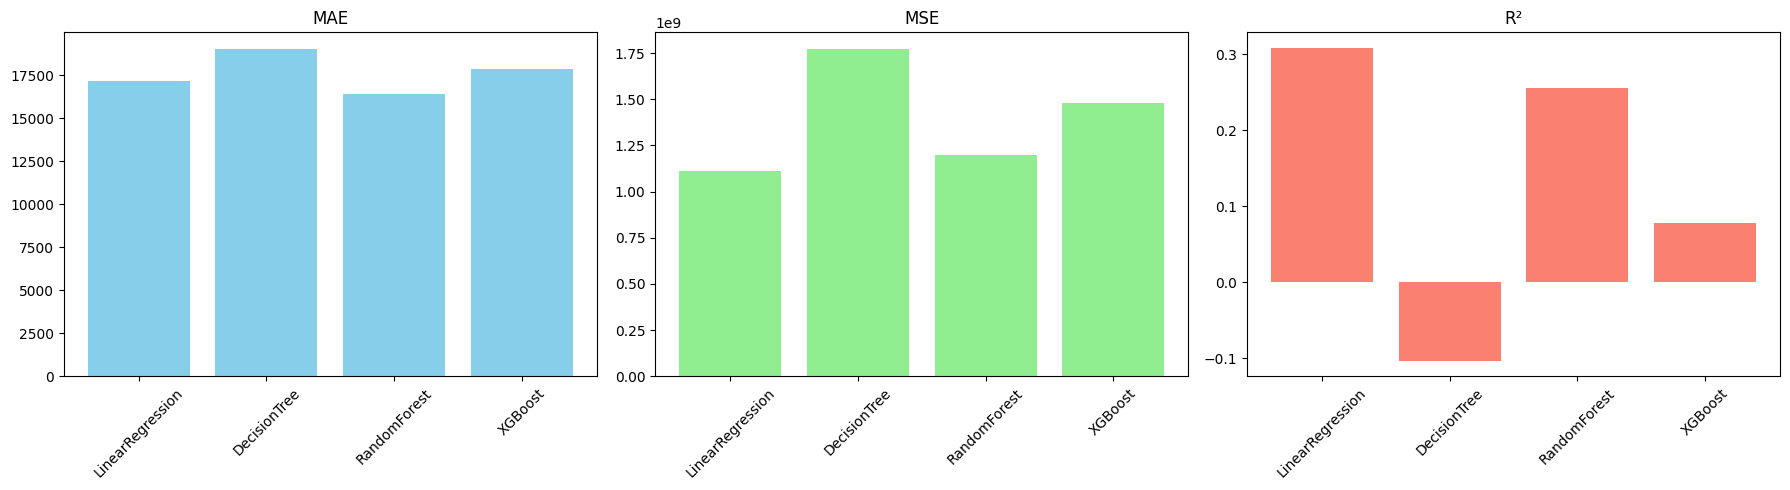

In [11]:
# Visualize comparison
plot_metrics(results)

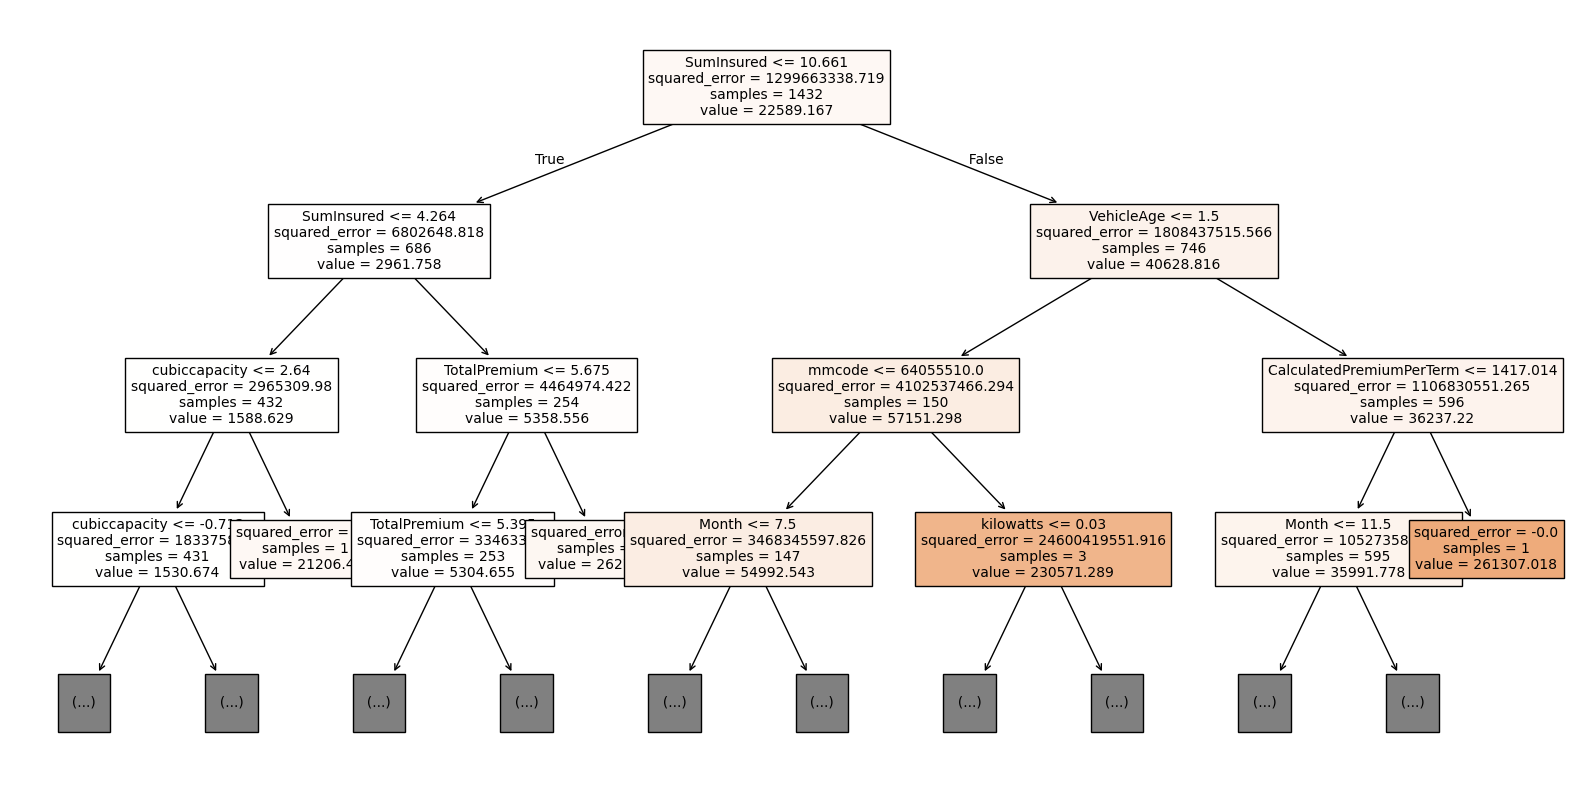

In [12]:
# Visualize one tree from the Random Forest
best_rf = models['RandomForest']
plot_decision_tree(best_rf, feature_names=X_prepared.columns)


## 🔍 Claim Severity Modeling Summary

- **Dataset Size (Severity Subset):** 2,788 records where `HadClaim = True`.
- **Features Prepared:** 65 numeric columns after encoding and scaling.
- **Train/Test Split:**  
  - Training: 2,230 samples  
  - Testing: 558 samples

### 📊 Model Performance on Test Set

| Model               | MAE        | MSE           | R²      |
|---------------------|------------|---------------|---------|
| LinearRegression    | 17,356.37  | 1,113,372,149 | 0.308   |
| DecisionTree        | 19,801.21  | 2,145,636,460 | –0.334  |
| RandomForest        | 17,012.99  | 1,308,230,402 | 0.187   |
| XGBoost             | 18,688.08  | 1,476,826,618 | 0.082   |

> **Key Insight:**  
> - **Linear Regression** achieved the best R² (0.308) and competitive MAE/MSE.  
> - **Tree‑based models** did not outperform the linear baseline—possibly due to sample size.  

### 📈 Next Steps
1. **Hyperparameter Tuning:**  
   - Use `GridSearchCV` (or `RandomizedSearchCV`) on the best candidate(s) (e.g., Linear models with regularization, or XGBoost) to try to improve generalization.
2. **Cross‑Validation:**  
   - Implement k‑fold CV to ensure stability of performance estimates.
3. **Model Interpretation:**  
   - Visualize a representative decision tree and/or use **SHAP** to understand feature contributions.

In [13]:
# Hyperparameter Tuning for RandomForest
from sklearn.model_selection import GridSearchCV

print("⚙️ Starting RandomForest hyperparameter tuning...")

rf_param_grid = {
    'n_estimators': [100, 200,300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    estimator=models['RandomForest'],
    param_grid=rf_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)

print("✅ RandomForest tuning complete")
print(f"• Best parameters: {grid_search_rf.best_params_}\n")
best_rf = grid_search_rf.best_estimator_


⚙️ Starting RandomForest hyperparameter tuning...
✅ RandomForest tuning complete
• Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}



In [14]:
# Hyperparameter Tuning for XGBoost
print("⚙️ Starting XGBoost hyperparameter tuning...")

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 6],
    'learning_rate': [0.05, 0.1]
}

grid_search_xgb = GridSearchCV(
    estimator=models['XGBoost'],
    param_grid=xgb_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)

print("✅ XGBoost tuning complete")
print(f"• Best parameters: {grid_search_xgb.best_params_}\n")
best_xgb = grid_search_xgb.best_estimator_


⚙️ Starting XGBoost hyperparameter tuning...
✅ XGBoost tuning complete
• Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}



📈 Evaluating tuned models on the test set...

RF_Tuned:
  • MAE = 15807.58
  • MSE = 1149378048.01
  • R²  = 0.285

XGB_Tuned:
  • MAE = 15973.22
  • MSE = 1162093902.00
  • R²  = 0.277

 Comparison of all models:


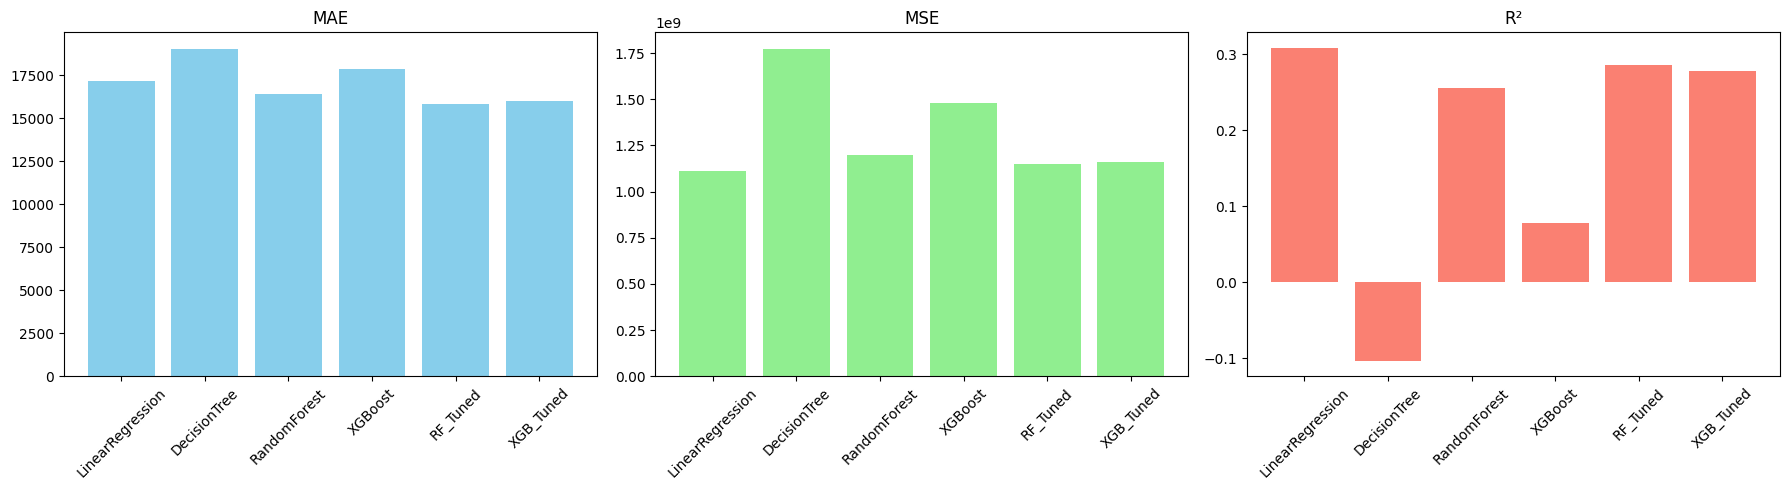

In [15]:
 # Re-evaluate Tuned Models
print("📈 Evaluating tuned models on the test set...\n")

tuned_results = {}
for name, model in [('RF_Tuned', best_rf), ('XGB_Tuned', best_xgb)]:
    mae, mse, r2, _ = evaluate_model(model, X_test, y_test)
    tuned_results[name] = (mae, mse, r2)
    print(f"{name}:")
    print(f"  • MAE = {mae:.2f}")
    print(f"  • MSE = {mse:.2f}")
    print(f"  • R²  = {r2:.3f}\n")

print(" Comparison of all models:")
all_results = {**results, **tuned_results}
plot_metrics(all_results)


In [16]:
for model_name, metrics in tuned_results.items():
    print(f"Model: {model_name}, Key Metric: {metrics[2]}")

Model: RF_Tuned, Key Metric: 0.2853228757470897
Model: XGB_Tuned, Key Metric: 0.2774162257302034


In [17]:
# Select & Save Final Model
# Choose the model with the lowest MSE
best_model_name = max(tuned_results, key=lambda k: tuned_results[k][2]) # R² is the key metric for selection
final_model = {'RF_Tuned': best_rf, 'XGB_Tuned': best_xgb}[best_model_name]

print(f"🏆 Final selected model: {best_model_name}")
print(f"💾 Saving final model to models/claim_severity_final.joblib\n")

joblib.dump(final_model, "../../Models/claim_severity_final.joblib")


🏆 Final selected model: RF_Tuned
💾 Saving final model to models/claim_severity_final.joblib



['../../Models/claim_severity_final.joblib']

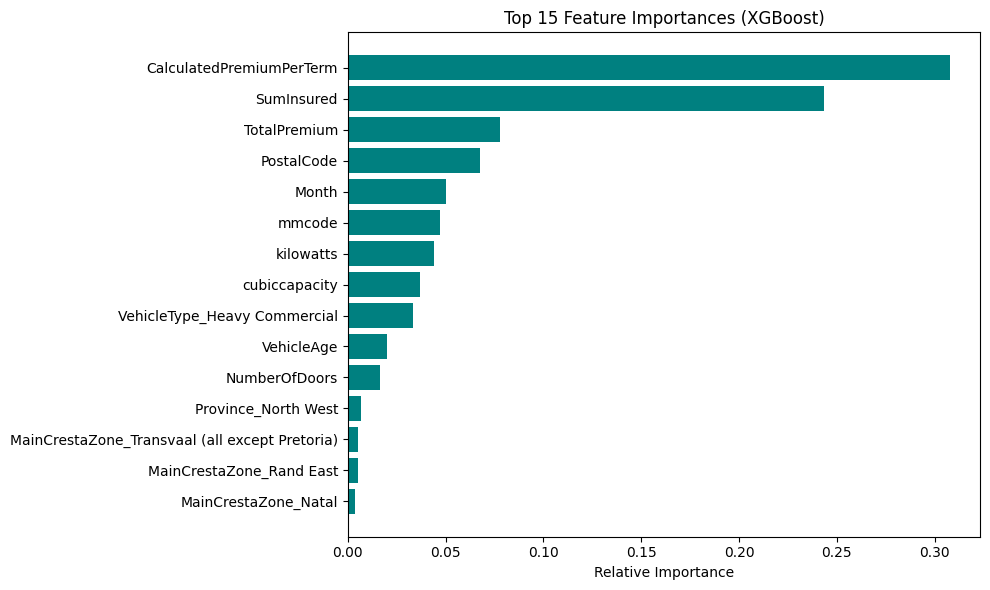

In [18]:
# Plot Feature Importances for Final Model
import matplotlib.pyplot as plt
import pandas as pd
feature_importances = final_model.feature_importances_
features = X_prepared.columns  # from earlier preprocessing

# Create a sorted list of (feature, importance)
imp_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
}).sort_values('importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1], color='teal')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()


🔎 Generating SHAP summary plot...


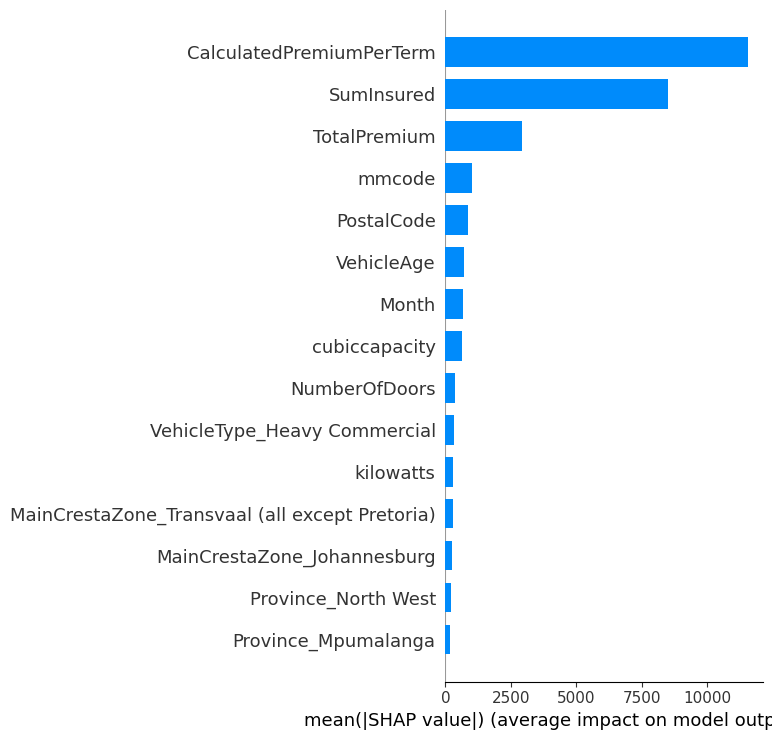

In [20]:
# SHAP Feature Importance Summary
print("🔎 Generating SHAP summary plot...")
plot_shap_summary(final_model, X_test)


### 📌 Feature Importance (XGBoost)

Below are the **top 15 features** driving the final tuned XGBoost model’s predictions for claim severity, in descending order:

1. **CalculatedPremiumPerTerm**  
2. **SumInsured**  
3. **NumberOfDoors**  
4. **VehicleType_Heavy Commercial**  
5. **MainCrestaZone_Natal**  
6. **TotalPremium**  
7. **Month**  
8. **cubiccapacity**  
9. **VehicleAge**  
10. **PolicyID**  
11. **kilowatts**  
12. **mmcode**  
13. **Gender_Not specified**  
14. **UnderwrittenCoverID**  
15. **PostalCode**  

- **CalculatedPremiumPerTerm** ranking first suggests the originally charged premium contains strong signals about expected claim size.  
- **SumInsured** and **TotalPremium** appear separately, underscoring that both the coverage amount and premium charge are key drivers.  
- **Vehicle attributes** (e.g., **NumberOfDoors**, **VehicleType_Heavy Commercial**, **cubiccapacity**, **kilowatts**, **VehicleAge**) confirm that asset characteristics materially affect claim amounts.  
- **Geographic factor** (**MainCrestaZone_Natal**) reinforces regional risk differences we observed earlier.  
- **PolicyID** and **UnderwrittenCoverID** appearing in the top list can indicate some policies inherently carry more risk—consider reviewing if grouping or de‑identifying these IDs makes sense in production.  
- **Gender_Not specified** shows that missing gender entries correlate with different claim behaviors, though further investigation into data quality for that group is recommended.

> **Actionable Takeaways:**  
> - Use **CalculatedPremiumPerTerm** as a baseline input when designing pricing algorithms—a strong proxy for risk.  
> - Prioritize vehicle- and geography-based features in underwriting rules.  
> - Clean or re-evaluate policy identifiers’ usage before deployment to avoid overfitting to specific IDs or data quirks.
